In [1]:
using Dates: DateTime, @dateformat_str
using CSV, DataFrames, LaTeXStrings, PyCall, PyPlot

@pyimport mpl_toolkits
Poly3DCollection = mpl_toolkits.mplot3d.art3d.Poly3DCollection

include("model.jl")

control (generic function with 4 methods)

In [2]:
function plot_power_and_reference(power, light_coverage, savepath)
    fig, ax_right = subplots(figsize=(3.5, 1.5))

    ax_right.xaxis.set_major_formatter(formatter)
    ax_right.xaxis.set_major_locator(locator)
    
    ax_left = ax_right.twinx()
    ax_right.plot(times, power, color="tab:orange", label=L"\sum_{i \in \mathcal{M}} p_i")
    ax_left.plot(
        times, light_coverage, 
        color="tab:blue", label=L"\sum_{k \in \mathcal{C}} \xi_k / \sum_{k \in \mathcal{C}} \xi^\bullet"
    )
    
    ax_right.set_xlabel("Time")
    ax_right.set_ylabel("[kW]")
    ax_left.set_ylim([0, 105])
    ax_left.set_ylabel(L"[\%]")
    
    ax_right.grid(true)
    
    ax_right.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower right",
        borderaxespad=0, ncol=1
    )
    ax_left.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
        borderaxespad=0, ncol=1
    )
    
    savefig(savepath)
end

plot_power_and_reference (generic function with 1 method)

In [3]:
# Optimization parameters
const GAMMA = 1
const ALBEDO = 0.1

# Data
const CROPS_FILE = "data/crops.csv"
const PANELS_FILE = "data/modules.csv"
const SOLAR_FILE = "data/solar.csv"

# PyPlot settings
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["figure.constrained_layout.use"] = true
rcParams["grid.alpha"] = 0.3
# rcParams["axes.spines.right"] = false
rcParams["axes.spines.top"] = false
rcParams["legend.frameon"] = false
rcParams["ytick.labelsize"] = 6
rcParams["xtick.labelsize"] = 6
rcParams["font.size"] = 8
rcParams["font.family"] = "sans"
rcParams["font.sans-serif"] = ["Computer Modern Roman"]
rcParams["text.usetex"] = true
rcParams["text.latex.preamble"] = "\\usepackage{amsmath}";
#     raw"\usepackage{amsfonts}", 
#     raw"\usepackage{amssymb}",
# ]

formatter = matplotlib.dates.DateFormatter("%H:%M")
locator = matplotlib.dates.HourLocator(interval=2)

# Colors
const COLOR_SHADOW_CROP = "black"
const COLOR_LIGHTING_CROP = "green"
const COLOR_PANEL = "blue"
const COLOR_SHADOW = "gray"
const COLOR_POLE = "black"

"black"

In [4]:
# Read data
print("Loading data... ")
crops = [
  Crop([crop.pos_east, crop.pos_north, crop.height], crop.to_shadow) 
  for crop in CSV.read(CROPS_FILE, DataFrame) |> eachrow
]

panels = [
  Panel(
    panel.width, 
    panel.depth, 
    [panel.pos_east, panel.pos_north, panel.height],
    panel.azimuth
  )
  for panel in CSV.read(PANELS_FILE, DataFrame) |> eachrow
]

suns = [
  Sun(sun.time, sun.dni, sun.dhi, sun.ghi, sun.azimuth, sun.elevation)
  for sun in CSV.read(SOLAR_FILE, DataFrame) |> eachrow
]
times = DateTime.([sun.time for sun in suns], dateformat"yyyy-mm-dd HH:MM:SS")
println("Done")

Loading data... Done


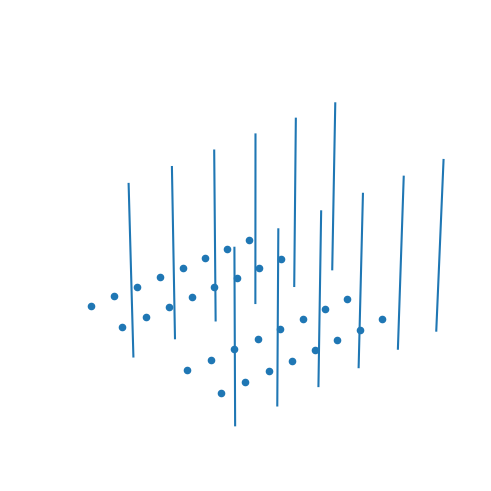

update_animation (generic function with 1 method)

In [5]:
# Base figure
fig = figure()
ax = fig.add_subplot(projection="3d")
ax.set_proj_type("persp")
ax.view_init(elev=30, azim=230, roll=0)
ax.set_axis_off()

# Set axes limit
min_xlim, max_xlim = Inf, 0
min_ylim, max_ylim = Inf, 0
for crop in crops
    min_xlim, max_xlim = min(min_xlim, crop.pos[1]), max(max_xlim, crop.pos[1])
    min_ylim, max_ylim = min(min_ylim, crop.pos[2]), max(max_ylim, crop.pos[2])
end

# Plot crops
crops_pos = stack(crop -> crop.pos, crops)
crops_plot = ax.scatter(crops_pos[1,:], crops_pos[2,:], crops_pos[3,:], depthshade=false)

# Plot modules poles
panels_pos = stack(panel -> panel.pos, panels)
panels_width = stack(panel -> panel.width, panels)
for i in [-1, 1]
   ax.stem(
       panels_pos[1,:] + i * 0.5panels_width,
       panels_pos[2,:],
       panels_pos[3,:],
       basefmt=" ",
       markerfmt=" "
   )
end

# Initialize panels and their shadow
panel_polygons = Poly3DCollection([zeros(4,3) for _ in 1:length(panels)], color=COLOR_PANEL)
shadow_polygons = Poly3DCollection([zeros(4,3) for _ in 1:length(panels)], color=COLOR_SHADOW)
ax.add_collection3d(panel_polygons)
ax.add_collection3d(shadow_polygons)

function update_animation(t)
    sun = suns[t]

    updated_panel_vertices, updated_panel_shadow = [], []
    for panel in panels
        push!(
            updated_panel_vertices,
            
        )
    end
end

In [6]:
total_power = Vector{Real}(undef, length(suns))
light_coverage = Vector{Real}(undef, length(suns))
crops_to_light = sum(crop -> 1 - Int(crop.to_shadow), crops)
for (t, sun) in enumerate(suns)
  # Optimal control policy
  tilt_vec, is_crop_shadowed = control(sun, panels, crops, ALBEDO, GAMMA)

  # KPIs to plot: total power produced and crops' light coverage 
  total_power[t] = sum(
    p(panel, sun, ALBEDO, tilt_vec[i,:])
    for (i, panel) in enumerate(panels)
  )
  light_coverage[t] = sum(1 .- is_crop_shadowed) / crops_to_light
end

[Sun @ 2024-10-26 05:30:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 05:45:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 06:00:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 06:15:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 06:30:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 06:45:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 07:00:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 07:15:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 07:30:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 07:45:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 08:00:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 08:15:00] Start constructing problem... Done. Status: OPTIMAL.
[Sun @ 2024-10-26 08:30:00] 

In [7]:
# Vertical panel policy
vertical_policy_total_power = Vector{Real}(undef, length(suns))
vertical_policy_light_coverage = Vector{Real}(undef, length(suns))
tilt = 0.99π/2 # π/2 is not admissible
for (t, sun) in enumerate(suns)
    vertical_policy_total_power[t] = sum(panel -> p(panel, sun, ALBEDO, u(tilt)), panels)
    # vertical_policy_light_coverage[t] = 
end

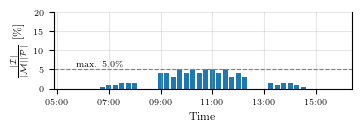

In [8]:
# Considered panel-crop pairs
spared_variable_ratio = Vector{Real}(undef, length(suns))
for (t, sun) in enumerate(suns)
    considered_panel_crop_pairs = sum(
        Int(can_panel_shadow_crop(panel, crop, sun, 100))
        for panel in panels, crop in crops
    )
    spared_variable_ratio[t] = considered_panel_crop_pairs / (length(crops) * length(panels))  
end

fig, ax = subplots(figsize=(3.5, 1.2))
ax.bar(times, 1e2spared_variable_ratio, linewidth=0, width=8e-3)
max_spared_variable_ratio = 1e2maximum(spared_variable_ratio)
ax.axhline(max_spared_variable_ratio, ls="--", lw=0.8, color="gray")
ax.text(times[2], 0.5 + max_spared_variable_ratio, "max. $(round(max_spared_variable_ratio))\\%", fontsize=6)

ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Time")
ax.set_ylabel(L"\frac{|\mathcal{I}|}{|\mathcal{M}||\mathcal{P}|} \ [\%]")

ax.set_ylim(0, 20)
ax.grid(true)

savefig("media/panel-crop-pairs.pdf")

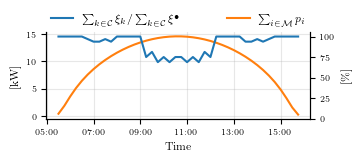

In [9]:
plot_power_and_reference(1e-3total_power, 1e2light_coverage, "media/gamma-$(GAMMA).pdf")